In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import gzip
from keras.utils import HDF5Matrix

Using TensorFlow backend.


In [3]:
import os
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Dropout, GlobalAveragePooling2D 
# Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from keras.applications.vgg19 import VGG19

%matplotlib inline

In [4]:
from utils.preprocess import DataGenerator
from utils.callbacks import PlotCurves
# from utils.load_data import load_data
from utils.comparams import auc

W0515 21:35:53.678690 140402307215488 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/utils/comparams.py:1: The name tf.local_variables_initializer is deprecated. Please use tf.compat.v1.local_variables_initializer instead.




from utils.load_data import load_data


x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', limit=10000, val_limit=10000)
len(x_train), len(x_valid)

In [5]:
data_dir = './data/macenko'

In [8]:
pc_train_x_h5 = os.path.join(data_dir, 'camelyonpatch_level_2_split_train_x_macenko_0_10000.h5.gz') 
x_train = HDF5Matrix(pc_train_x_h5, 'x')

pc_train_y_h5 = os.path.join(data_dir, 'camelyonpatch_level_2_split_train_y_macenko_0_10000.h5.gz') 
pc_valid_y_h5 = os.path.join(data_dir, 'camelyonpatch_level_2_split_valid_y_macenko_0_10000.h5.gz')
y_train = HDF5Matrix(pc_train_y_h5, 'y')
y_valid = HDF5Matrix(pc_valid_y_h5, 'y')

pc_valid_x_h5 = os.path.join(data_dir, 'camelyonpatch_level_2_split_valid_x_macenko_0_10000.h5.gz') 
x_valid = HDF5Matrix(pc_valid_x_h5, 'x')

In [9]:
x_train = [x.astype(np.uint8) for x in x_train[:x_train.shape[0]]]
x_valid = [x.astype(np.uint8) for x in x_valid[:x_valid.shape[0]]]

In [10]:
del pc_train_x_h5
del pc_train_y_h5
del pc_valid_y_h5
del pc_valid_x_h5

### Data Generator

x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', limit=10000, val_limit=None)
len(x_train), len(x_valid)

In [11]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

## MODEL

In [13]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [14]:
x = vgg19.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities

model = Model(inputs=vgg19.input, outputs=y)

# Train only the top layer
for layer in vgg19.layers:
    layer.trainable = False

model.summary()

### Compile

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [16]:
optimizer = Adam(lr=0.001)
# , beta_1=0.9, beta_2=0.999)
loss = 'categorical_crossentropy'
metrics = ['acc', auc]

In [17]:
model.compile(optimizer, loss, metrics)

W0515 21:37:34.449946 140402307215488 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0515 21:37:34.464056 140402307215488 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/utils/comparams.py:7: The name tf.metrics.auc is deprecated. Please use tf.compat.v1.metrics.auc instead.

W0515 21:37:34.506221 140402307215488 deprecation.py:323] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/tensorflow/python/ops/metrics_impl.py:808: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


## Train the model

In [18]:
# directory to save the best model
file_dir = './Model'
if not os.path.exists(file_dir):
    os.mkdir(file_dir)
    
model_name = 'stain_norm_VGG19_model_10K'
    
network_filepath = os.path.join(file_dir, model_name + '.h5')

In [19]:
# Define batch size.
batch_size = 128
n_epoch = 10
# time_limit = 500 # time limit in minute (500 -> 8 hrs and 20 min)

# Parameters for generators
params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
    'shuffle': True
}

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **params)
validation_generator = DataGenerator(partition['validation'], x_valid, val_labels, **params)

#a function to save last_model compatible with the on_interrupt handler of TimerCallback
def saveWeights(model, elapsed):
    model.save_weights(os.path.join(file_dir, model_name + '_weights.h5'))


# Callbacks,
callbacks = [PlotCurves(), learning_rate_reduction]#, TimerCallback(1, on_interrupt=saveWeights)]
#roc_callback(training_data=training_generator,validation_data=validation_generator)

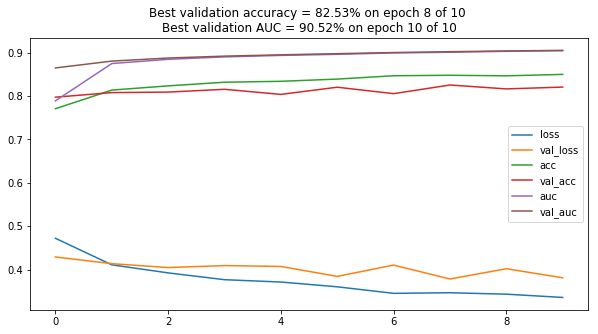

In [20]:
# Training with ...
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)

In [21]:
model.save(network_filepath)

### Runs

In [17]:
type(x_train[0])

numpy.ndarray

In [18]:
type(x_train[0][0])

numpy.ndarray

In [19]:
type(x_train[0][0][0])

numpy.ndarray

In [22]:
type(x_train[0][0][0][0])

numpy.uint8

In [24]:
type(x_train)

keras.utils.io_utils.HDF5Matrix

In [33]:
type(x_train_int8[0])

numpy.ndarray

In [34]:
type(x_train_int8[0][0])

numpy.ndarray

In [35]:
type(x_train_int8[0][0][0])

numpy.ndarray

In [36]:
type(x_train_int8[0][0][0][0])

numpy.uint8

In [31]:
x_train_int8 = [x.astype(np.uint8) for x in x_train[:x_train.shape[0]]]

In [32]:
type(x_train_int8[0][0][0][0])

numpy.uint8